# Определение возраста покупателей

## Исследовательский анализ данных

In [1]:
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
#загрузка данных
labels = pd.read_csv('/datasets/faces/labels.csv')
train_datagen = ImageDataGenerator(rescale=1./255)
train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=12345) 

Found 7591 validated image filenames.


In [3]:
#размер выборки
labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


In [4]:
#распределения возраста
labels.describe()

,real_age
count,7591.000000
mean,31.201159
std,17.145060
min,1.000000
25%,20.000000
50%,29.000000
75%,41.000000
max,100.000000


/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


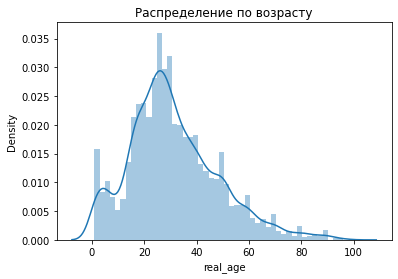

In [5]:
#график распределения возраста
plt.figure()
sns.distplot(labels.real_age, bins=50)
plt.title("Распределение по возрасту")
plt.show()

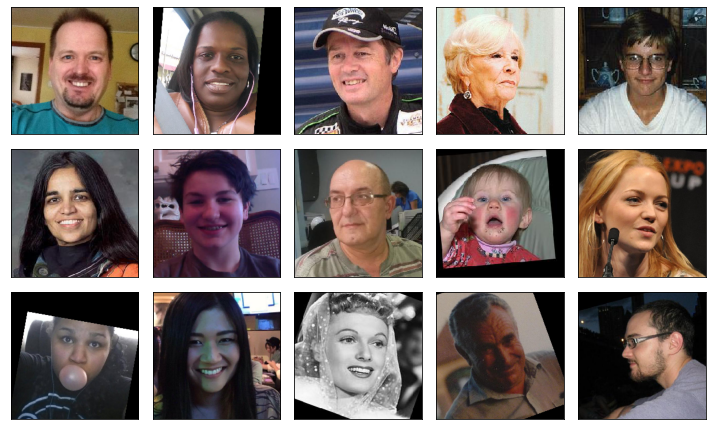

In [6]:
#Напечатайте на экране 10–15 фотографий и посмотрите, как устроен датасет.
features, target = next(train_gen_flow)

fig = plt.figure(figsize=(10,10))
for i in range(15):
    fig.add_subplot(5, 5, i+1)
    plt.imshow(features[i])
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()

Вывод

Размер выборки - 7591. Больше всего фотографий людей в возрасте 25-30 лет.

<div class="alert" style="background-color:#ead7f7;color:#8737bf">
    <font size="3"><b>Комментарий студента:</b></font>
   
Фотографии все разнообразные: цветные и чб, есть фото в профиль, с предметами (очки, жвачка, микрофон). Некоторые фото как-будто не подходят по формату.

</div>

## Обучение модели

Перенесите сюда код обучения модели и её результат вывода на экран.


(Код в этом разделе запускается в отдельном GPU-тренажёре, поэтому оформлен не как ячейка с кодом, а как код в текстовой ячейке)

```python


from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Flatten, Conv2D, AvgPool2D, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.resnet import ResNet50
import pandas as pd
 
def load_train(path):
    labels = pd.read_csv(path+'labels.csv')
    train_datagen = ImageDataGenerator(rescale=1./255, horizontal_flip=True, validation_split=0.25)
 
    train_datagen_flow = train_datagen.flow_from_dataframe(
      dataframe=labels,
      directory=path + 'final_files/',
      x_col='file_name',
      y_col='real_age',
      target_size=(224, 224),
      class_mode='raw',
      batch_size=32,
      subset='training',
      seed=12345)
    return train_datagen_flow
 
def load_test(path):
    labels = pd.read_csv(path +'labels.csv')
    test_datagen = ImageDataGenerator(rescale=1./255, horizontal_flip=True, validation_split=0.25)
    test_datagen_flow = test_datagen.flow_from_dataframe(
        dataframe= labels,
        directory= path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='validation',
        seed=12345)
    return test_datagen_flow
 
def create_model(input_shape):
    optimizer = Adam(lr=0.0001)
    backbone = ResNet50(input_shape=input_shape,
                        weights='imagenet',
                        include_top=False)
 
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu'))
    model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mae'])
 
    return model
 
 
def train_model(model, train_data, test_data, batch_size=None, epochs=10,
               steps_per_epoch=None, validation_steps=None):
    model.fit(train_data,
              validation_data=test_data,
              batch_size=batch_size, epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2)
 
    return model

```




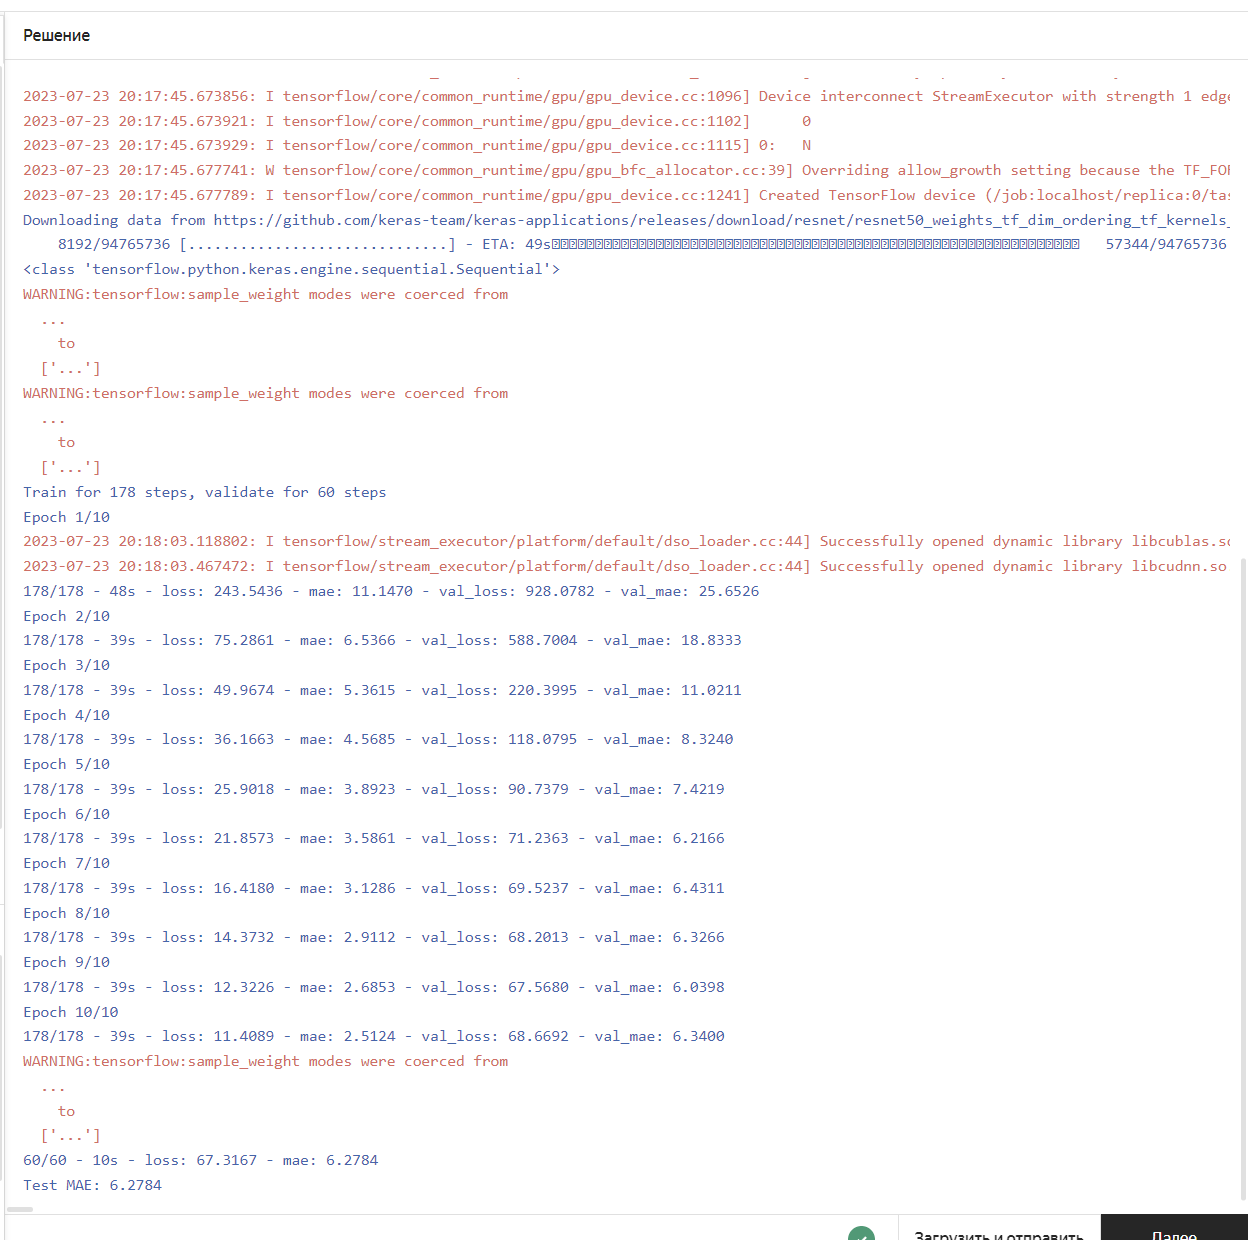

Вывод

Модель построена на ResNet50.  Финальное MAE 6.27. На тренировочной выборке получилось понизить до 2.5

## Анализ обученной модели

Провели анализ данных. Больше всего фотографий людей в возрасте 25-30 лет. На этих данных обучили модель построенную на ResNet50. Получили MAE 6.27.